In [ ]:
pip install qiskit

In [ ]:
pip install qiskit-aer-gpu-cu11

In [2]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector
from qiskit.quantum_info import DensityMatrix, Statevector, SparsePauliOp, Operator, partial_trace, entropy

from spin import *
from trotter import *
import time

In [7]:
simulator_gpu = AerSimulator(method='statevector', device='CPU')
# simulator_gpu = AerSimulator(method='statevector', device='GPU')
print(simulator_gpu.available_devices())
print(simulator_gpu.available_methods())

('CPU',)
('automatic', 'statevector', 'density_matrix', 'stabilizer', 'matrix_product_state', 'extended_stabilizer', 'unitary', 'superop')


In [8]:
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter
import numpy as np

n = 20
QIMF = Nearest_Neighbour_1d(n, hx=0.8090, hy=0.9045, Jx=1, pbc=False)

H = QIMF.ham_xyz
print(H)

init = Statevector.from_label("10101010")
t, dt = 10.0, 0.1
r = int(round(t / dt))

[SparsePauliOp(['IIIIIIIIIIIIIIIIIIXX', 'IIIIIIIIIIIIIIIIIXXI', 'IIIIIIIIIIIIIIIIXXII', 'IIIIIIIIIIIIIIIXXIII', 'IIIIIIIIIIIIIIXXIIII', 'IIIIIIIIIIIIIXXIIIII', 'IIIIIIIIIIIIXXIIIIII', 'IIIIIIIIIIIXXIIIIIII', 'IIIIIIIIIIXXIIIIIIII', 'IIIIIIIIIXXIIIIIIIII', 'IIIIIIIIXXIIIIIIIIII', 'IIIIIIIXXIIIIIIIIIII', 'IIIIIIXXIIIIIIIIIIII', 'IIIIIXXIIIIIIIIIIIII', 'IIIIXXIIIIIIIIIIIIII', 'IIIXXIIIIIIIIIIIIIII', 'IIXXIIIIIIIIIIIIIIII', 'IXXIIIIIIIIIIIIIIIII', 'XXIIIIIIIIIIIIIIIIII', 'IIIIIIIIIIIIIIIIIIIX', 'IIIIIIIIIIIIIIIIIIXI', 'IIIIIIIIIIIIIIIIIXII', 'IIIIIIIIIIIIIIIIXIII', 'IIIIIIIIIIIIIIIXIIII', 'IIIIIIIIIIIIIIXIIIII', 'IIIIIIIIIIIIIXIIIIII', 'IIIIIIIIIIIIXIIIIIII', 'IIIIIIIIIIIXIIIIIIII', 'IIIIIIIIIIXIIIIIIIII', 'IIIIIIIIIXIIIIIIIIII', 'IIIIIIIIXIIIIIIIIIII', 'IIIIIIIXIIIIIIIIIIII', 'IIIIIIXIIIIIIIIIIIII', 'IIIIIXIIIIIIIIIIIIII', 'IIIIXIIIIIIIIIIIIIII', 'IIIXIIIIIIIIIIIIIIII', 'IIXIIIIIIIIIIIIIIIII', 'IXIIIIIIIIIIIIIIIIII', 'XIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.   +0.j, 1.   +0.j, 1. 

In [9]:
trotter = PauliEvolutionGate(H, time=dt, synthesis=LieTrotter())
qc = QuantumCircuit(n)
start_time = time.time()
for s in range(1, r+1):
    qc.append(trotter, range(n))
    qc.save_statevector(label=f"sv_{s}")

res = simulator_gpu.run(transpile(qc, simulator_gpu), initial_statevector=init.data).result()
data = res.data(0)
states = [data[f"sv_{s}"] for s in range(1, r+1)]

entropy_list = []
# when n=14, need 5 mins for one step
for s in range(1, r):
    print(s)
    # rdm1 = partial_trace(DensityMatrix(states[s-1]), [0])
    # rdm2 = partial_trace(DensityMatrix(states[s-1]), [0, 1])
    # rdm3 = partial_trace(DensityMatrix(states[s-1]), [0, 1, 2])
    # rdm4 = partial_trace(DensityMatrix(states[s-1]), [0, 1, 2, 3])
    rdm1 = partial_trace(states[s-1], list(range(0, n-1)))
    # print(len(rdm1.data))
    rdm2 = partial_trace(states[s-1], list(range(0, n-2)))
    rdm3 = partial_trace(states[s-1], list(range(0, n-3)))
    rdm4 = partial_trace(states[s-1], list(range(0, n-4)))
    temp_entropy = [entropy(rdm1), entropy(rdm2), entropy(rdm3), entropy(rdm4)]
    print(temp_entropy)
    entropy_list.append(temp_entropy)
total_time = time.time() - start_time
print("total time", total_time)

1
[0.08057237093704744, 0.080572370937057, 0.0805723709370612, 0.08057237093705913]
2
[0.2337767006408482, 0.2338393571083688, 0.2338393571083995, 0.23383935710838416]
3
[0.3937026786691774, 0.3946266726437778, 0.3946265119269267, 0.3946265119269322]
4
[0.5188099182604046, 0.5239537838697443, 0.5239485443053847, 0.5239485505634066]
5
[0.5864854127708383, 0.6050673241813358, 0.605007333748628, 0.6050075263401113]
6
[0.5946508224848737, 0.646049709207129, 0.645673785980124, 0.645675982164028]
7
[0.5632816348453906, 0.6773149467517909, 0.6758744765357064, 0.6758870793550337]
8
[0.5310762236359147, 0.7343859233446804, 0.7308578815373222, 0.7308982387018276]
9
[0.5396982059914226, 0.8311900235548614, 0.8257509189702381, 0.8258213655919978]
10
[0.606768079743865, 0.9507268458374355, 0.94683014918388, 0.9468616242865668]
11
[0.7136397152099783, 1.0619817449284286, 1.0673324112467109, 1.06715105178035]
12
[0.8234246544768153, 1.1413887614080067, 1.166998811554125, 1.1663928888714883]
13
[0.904

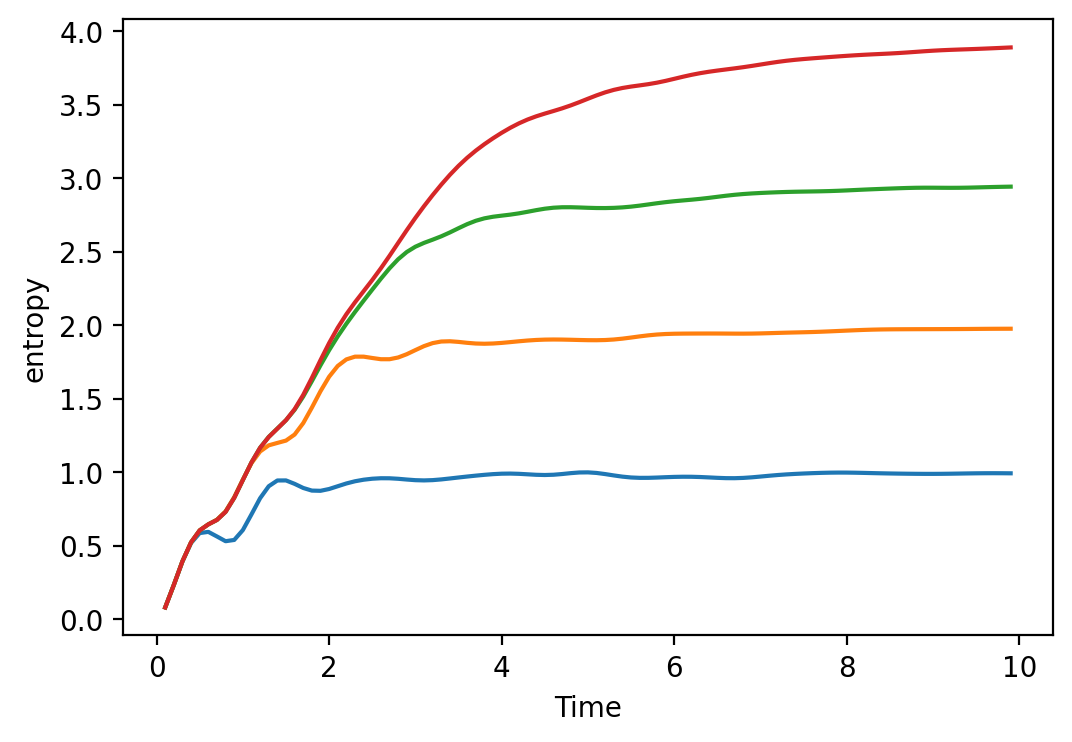

<Figure size 640x480 with 0 Axes>

In [10]:
import matplotlib.pyplot as plt
import numpy as np

dt = 0.1
steps = len(entropy_list)
times = np.arange(1, steps+1) * dt

plt.figure(figsize=(6,4))
plt.plot(times, entropy_list)
plt.xlabel("Time")
plt.ylabel("entropy")
plt.show()

plt.savefig("entropy_gpu.pdf")